In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt


In [9]:
# 1. Data Collection and Preprocessing
class StockDataPreprocessor:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.X = None
        self.y = None

    def download_data(self):
        # Download stock data
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        return self

    def calculate_technical_indicators(self):
        # Calculate technical indicators
        self.data['MA20'] = self.data['Close'].rolling(window=20).mean()
        self.data['MA50'] = self.data['Close'].rolling(window=50).mean()

        # RSI Calculation
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands - Use a single column approach
        bb_middle = self.data['Close'].rolling(window=20).mean()
        bb_std = self.data['Close'].rolling(window=20).std()

        self.data['BB_Upper'] = bb_middle + (2 * bb_std)
        self.data['BB_Lower'] = bb_middle - (2 * bb_std)

        # Momentum
        self.data['Momentum'] = self.data['Close'].diff(10)

        return self

    def prepare_sequences(self, sequence_length=30, prediction_horizon=1):
        # Drop NaN values
        self.data.dropna(inplace=True)

        # Select features
        features = ['Close', 'Volume', 'MA20', 'MA50', 'RSI', 'BB_Upper', 'BB_Lower', 'Momentum']

        # Normalize features
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(self.data[features])

        # Create sequences
        X, y = [], []
        for i in range(len(scaled_features) - sequence_length - prediction_horizon + 1):
            X.append(scaled_features[i:i+sequence_length])
            y.append(scaled_features[i+sequence_length+prediction_horizon-1][0])

        self.X = np.array(X)
        self.y = np.array(y)

        return self.X, self.y, scaler

In [3]:
# 2. Transformer Model Architecture
class StockTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, hidden_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding

        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)

        x = x.mean(dim=0)
        return self.fc(x)

In [4]:
# 3. Training Pipeline
def train_model(X, y, test_size=0.2, epochs=100, learning_rate=0.001):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    # Initialize model
    model = StockTransformer(
        input_dim=X_train.shape[2],
        hidden_dim=64,
        num_layers=2,
        num_heads=4,
        output_dim=1
    )

    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with early stopping
    best_loss = float('inf')
    patience = 10
    trigger_times = 0

    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs.squeeze(), y_test)

            training_losses.append(loss.item())
            validation_losses.append(test_loss.item())

            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

            # Early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                trigger_times = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    break

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    return model, X_test, y_test

In [11]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # Convert y_test to a NumPy array if it's a Tensor
        if torch.is_tensor(y_test):
            y_test = y_test.numpy()

        # Ensure predictions are NumPy array
        predictions = model(torch.FloatTensor(X_test)).detach().numpy()

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)

    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')

    # Visualize predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='red', linestyle='--')
    plt.title('Stock Price: Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

    return predictions

In [13]:
def explain_predictions(model, X_test):
    # Wrap PyTorch model for SHAP
    def model_predict(x):
        # Reshape input to match model's expected input
        x_reshaped = torch.FloatTensor(x).view(-1, X_test.shape[1], X_test.shape[2])
        return model(x_reshaped).detach().numpy()

    # Flatten the input for SHAP
    # We'll use the last time step features for explanation
    X_test_flat = X_test[:, -1, :]  # Take the last time step of each sequence

    try:
        # Use a subset of data for explanation to reduce computational complexity
        explainer = shap.KernelExplainer(model_predict, X_test_flat[:50])
        shap_values = explainer.shap_values(X_test_flat[:50])

        # Plot SHAP summary
        plt.figure(figsize=(10, 6))
        feature_names = ['Close', 'Volume', 'MA20', 'MA50', 'RSI', 'BB_Upper', 'BB_Lower', 'Momentum']
        shap.summary_plot(shap_values, X_test_flat[:50], feature_names=feature_names)
        plt.title('Feature Importance in Stock Price Prediction')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP explanation error: {e}")
        print("Skipping SHAP analysis")

In [14]:
def main():
    # Configure parameters
    ticker = 'SPY'
    start_date = '2015-12-01'
    end_date = '2018-01-31'

    # Data Preprocessing
    preprocessor = StockDataPreprocessor(ticker, start_date, end_date)
    preprocessor.download_data().calculate_technical_indicators()
    X, y, scaler = preprocessor.prepare_sequences()

    # Model Training
    model, X_test, y_test = train_model(X, y)

    # Model Evaluation
    predictions = evaluate_model(model, X_test, y_test)

    # Explainability (with optional skipping)
    try:
        explain_predictions(model, X_test)
    except Exception as e:
        print(f"Could not generate SHAP explanation: {e}")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0, Train Loss: 0.5271, Test Loss: 0.0097
Epoch 1, Train Loss: 0.1507, Test Loss: 0.2146
Epoch 2, Train Loss: 0.0293, Test Loss: 0.3271
Epoch 3, Train Loss: 0.0642, Test Loss: 0.2384
Epoch 4, Train Loss: 0.0355, Test Loss: 0.1286
Epoch 5, Train Loss: 0.0172, Test Loss: 0.0665
Epoch 6, Train Loss: 0.0269, Test Loss: 0.0517
Epoch 7, Train Loss: 0.0352, Test Loss: 0.0586
Epoch 8, Train Loss: 0.0313, Test Loss: 0.0806
Epoch 9, Train Loss: 0.0226, Test Loss: 0.1181
Epoch 10, Train Loss: 0.0173, Test Loss: 0.1606
Early stopping at epoch 10


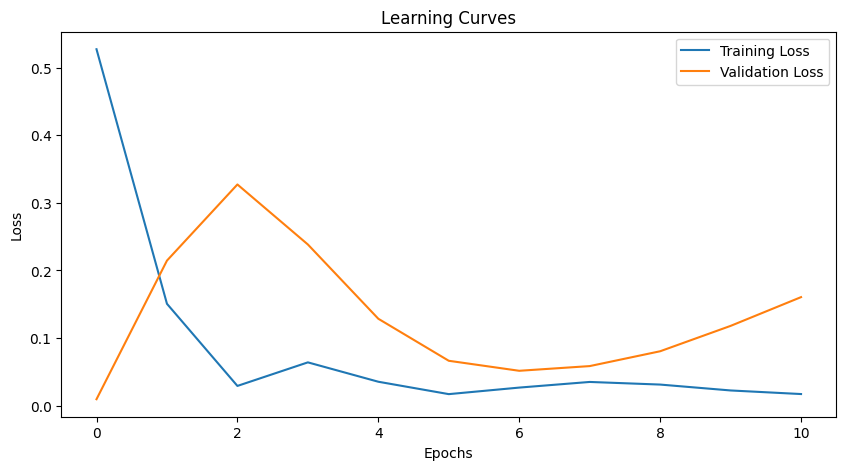

Mean Absolute Error: 0.0805
Mean Squared Error: 0.0089
Root Mean Squared Error: 0.0943


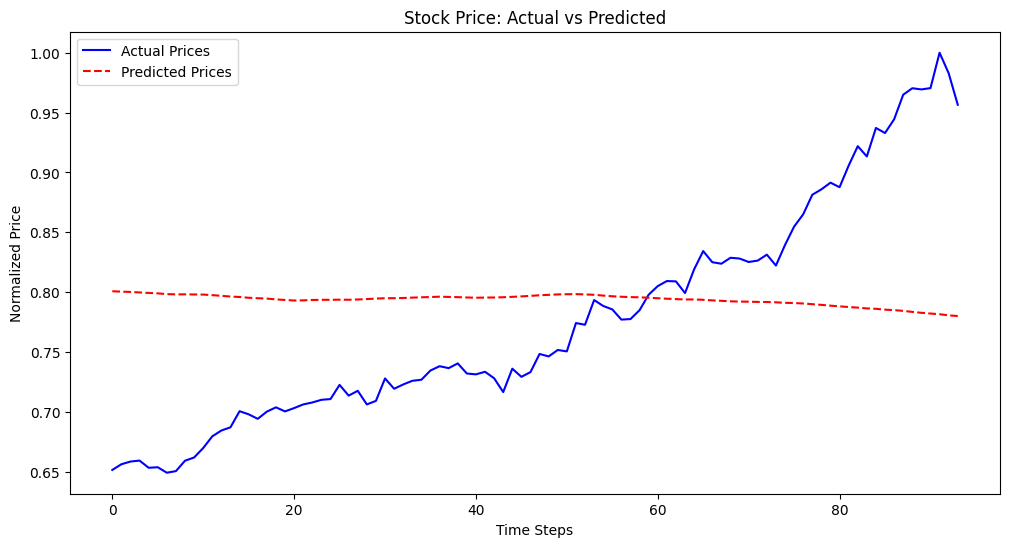

SHAP explanation error: Unknown type passed as data object: <class 'torch.Tensor'>
Skipping SHAP analysis


In [15]:
# Execute the main function
if __name__ == '__main__':
    main()